# AirBnB Barcelona: An analysis of listings

Using the recommended <a href="https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome">CRISP-DM</a> methodology on the <a href="https://www.udacity.com/course/data-scientist-nanodegree--nd025">Data Science Nanodegree by Udacity</a>, we analyse the AirBnB Barcelona July 2019 dataset, focusing on the following 3 aspects:

1. Is the price affected by the location?
2. Which locations receive the most reviews? What is the split between accomodation type and its reviews? What's the top reviewed property?
3. Can we predict the mean price or avg reviews based on seasonality?

There's an initial CRISP-DM model suggest doing the above following these steps:

* Business Understanding
* Data Understanding
* Data Preparation
* Data Modelling
* Evaluation
* Deployment

Let's start!

## Data Gathering, assesing and cleaning

In [52]:
# Load libraries we'll use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

%matplotlib inline

### Data loading
On this step we'll upload the data to be processed. There are few files available on Kaggle for AirBnB Barcelona (up to July 2019) so let's explore them and decide which ones will help us answer our pre-defined questions.

In [ ]:
# load the data. There's more data available, but we'll use these 3 sets initially.
df_cal = pd.read_csv('./data/calendar.csv.gz', compression='gzip')
df_lis = pd.read_csv('./data/listings.csv')
df_lis2 = pd.read_csv('./data/listings.csv.gz', compression='gzip')
df_rev = pd.read_csv('./data/reviews.csv')
df_rev2 = pd.read_csv('./data/reviews.csv.gz', compression='gzip')
df_nei = pd.read_csv('./data/neighbourhoods.csv')
df_geo = pd.read_json('./data/neighbourhoods.geojson')

One or more columns have been imported in the incorrect type. This will be addressed later.

#### Calendar file
This file contains information detailed calendar data for listings in Barcelona. This file will show the price of the listing and wether it was available or not on that date.

In [ ]:
df_cal.head(1)

#### Listings files
There are 2 files available for listings. One with the summary information of listings and another with the summary information. For the purpose of this project, we'll use the one with the summary information.

In [4]:
df_lis.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18666,Flat with Sunny Terrace,71615,Mireia And Maria,Sant Martí,el Camp de l'Arpa del Clot,41.40889,2.18555,Entire home/apt,130,3,1,2015-10-10,0.02,31,182


In [5]:
df_lis2.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18666,https://www.airbnb.com/rooms/18666,20190710134514,2019-07-10,Flat with Sunny Terrace,"Apartment located near the ""Plaza de las Glori...",Nice apartment situated on the penthouse floor...,"Apartment located near the ""Plaza de las Glori...",none,Apartment in Barcelona near to the Plaza de la...,...,f,f,flexible,f,f,31,31,0,0,0.02


#### Review files
There are also 2 files for reviews. One contains the summary as in just the date and review ID (capturing the fact that there was a review) and another with the comment of the review as well as the name of the reviewer.
The summary information of the amount of reviews is contained in the listing file we'll be using so, for now, we'll not be using this file.

In [6]:
df_rev.head(1)

,listing_id,date
0,18666,2015-10-10


In [7]:
df_rev2.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,18666,50158511,2015-10-10,1559265,Jody,Very nice flat. We had easy transportation to ...


#### Geolocation files
There are also 2 files available that relate to geo location, defining districts and neighbourhoods within Barcelona city. This could help draw visually where the properties are. For the initial purpose of the analysis, we'll leave these 2 files to the side as well but may come back to them on the visualization part.

In [8]:
df_nei.head(1)

,neighbourhood_group,neighbourhood
0,Ciutat Vella,el Barri Gòtic


In [9]:
df_geo.head(1)

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Mult..."


### Data wrangling

Now that we have picked the files we want to work with (calendar and listings), let's see what their structure is and whether they require cleansing. This will result in a single dataframe containing all the details we are after.

#### Calendar File

For the Calendar file, the following cleaning will be performed:
* Convert price and price_adjusted columns from strings to numerical values
* Add year and month columns to facilitates plotting later
* Remove "odd" prices of "9999.0" as they only represent 0.02% of total.  
* Remove missing values for price and price_adjusted, as they are only on 2 listings of the set.


In [10]:
print("The calendar file contains", df_cal.shape[0], "rows and", df_cal.shape[1], "columns.")
print("The columns are:", list(df_cal.columns))

The calendar file contains 7239045 rows and 7 columns.
The columns are: ['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']


In [11]:
# Convert price and price_Adjusted to float
df_cal["price"] = df_cal["price"].replace('[\$,]', '', regex=True).astype(float)
df_cal["adjusted_price"] = df_cal["adjusted_price"].replace('[\$,]', '', regex=True).astype(float)

In [12]:
# Add year and month columns
df_cal['date'] = pd.to_datetime(df_cal['date'])
df_cal['month']=df_cal.date.dt.month
df_cal['year']=df_cal.date.dt.year

In [13]:
# Inspect null values
df_cal[df_cal["price"].isnull() == True].listing_id.unique()

array([10410622, 17486763])

There seem to be 2 listings that have null prices for some periods of time. Let's see if they always have null prices or whether they have it for only a period of time

In [14]:
df_cal[df_cal["listing_id"].isin([10410622, 17486763])==True].groupby("listing_id").price.unique()

listing_id
10410622    [144.0, 134.0, 154.0, 211.0, 124.0, 72.0, 160....
17486763    [75.0, 50.0, 77.0, 81.0, 80.0, 85.0, 74.0, 55....
Name: price, dtype: object

Both seem to have other pricing values for other periods. Let's plot their pricing to spot the periods for which the pricing is missing

In [15]:
df_calsub = df_cal[df_cal["listing_id"].isin([10410622, 17486763])==True]
df_calsub = df_calsub[["listing_id","date", "price"]]
df_calsub = df_calsub.pivot(index='date', columns='listing_id', values='price')

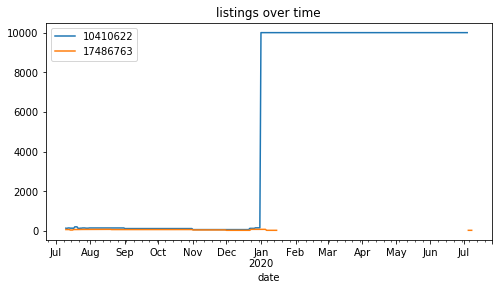

In [16]:
#plot data
df_calsub[10410622].plot(label='10410622'
                           , figsize=(8,4)
                           , title='listings over time'
                           , kind='line');
df_calsub[17486763].plot(label='17486763');
plt.legend();

This has shown that there are 2 peculiarities about these two listings. On one of them, it seems that the price for future listings is missing over a period, for the other one, there are some nulls but also a huge price increase. 

We could find a price to fill in for the second case and similarly for the first one, but as we're looking at missing values and looking into this isn't focused on this peculiarity in the data (price of 9999.99), we'll exclude these two listings from our study for now.

In [18]:
total_listings = df_cal.listing_id.nunique()
weird_listings = df_cal[df_cal['price']==9999].listing_id.nunique()
proportion =  weird_listings / total_listings

print("There are", total_listings ,"unique listings on the calendar file, of which", weird_listings, "contain prices of 9999.0")
print("which represents around","{0:.2f}%".format(proportion), "of the total listings for the period given")

There are 19833 unique listings on the calendar file, of which 479 contain prices of 9999.0
which represents around 0.02% of the total listings for the period given


Given that it's a very small subset of the data, only 0.02% of all listings and that this weird price change isn't in the focus of our 3 main questions, I'll discard those listings from the dataset. Perhaps this would be a nice future line of focus: <i>Do people use pricing to avoid unlisting a property in AirBnB?</i>

In [19]:
cal_cle = df_cal[~df_cal.isin(df_cal[df_cal['price']==9999].listing_id)]

In [20]:
# and we'll remove the missing values as well, given how few there are
cal_cle = cal_cle.dropna()

#### Listing file

For the Listing file, the following cleaning will be performed:
* Rename column id to listing_id to match calendar file column names
* Remove the listing ids which had been already removed from the Calendar file on previous steps.


In [21]:
print("The listing file contains", df_lis.shape[0], "rows and", df_lis.shape[1], "columns.")
print("The columns are:", list(df_lis.columns))

The listing file contains 19833 rows and 16 columns.
The columns are: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [22]:
# rename the column id for listing_id to match it with the calendar file
df_lis.rename(columns={"id": "listing_id"}, inplace=True)

To make sure of consistency, we also need to remove the listings we removed from the calendar file on this file, to ensure we are looking at the same listings:

In [23]:
lis_cle = df_lis[~df_lis.isin(df_cal[df_cal['price']==9999].listing_id)]

Most of the data is present, except for host_name, name and the reviews. It could be that they don't have reviews or that it's missing from this file. 

#### Reviews file

* no actions required on this file

In [24]:
df_rev.isnull().sum()

listing_id    0
date          0
dtype: int64

There are no missing values in the reviews file. 

#### Final result

The files we need to use are:
* cal_cle for the cleaned calendar file
* lis_cle for the cleaned listing file
* df_rev for the reviews file

As we'll be using the Calendar and Listing file for our analysis, let's create a merged dataframe that will contain the inner join outcome of the two.
* full_liscal: merge of cal and lis

In [25]:
# we select only the features we're intersted in from the listings and calendar files and merge them
full_liscal = pd.merge(lis_cle[['listing_id','neighbourhood_group', 'room_type']], cal_cle[['listing_id','date','year','month','price','available']], on='listing_id', how='inner')
full_liscal.head(2)

,listing_id,neighbourhood_group,room_type,date,year,month,price,available
0,18666,Sant Martí,Entire home/apt,2019-07-10,2019,7,130.0,f
1,18666,Sant Martí,Entire home/apt,2019-07-11,2019,7,130.0,f


## Data analysis, modelling and visualizations

Let's make copies of the datasets to facilitate exploration.

In [26]:
lis = lis_cle.copy()
cal = cal_cle.copy()
rev = df_rev.copy()
full = full_liscal.copy()

### 1) Is the price affected by the location?

In order to answer question this question, let's try to see how many properties there are per neighbourhood_group and room type.

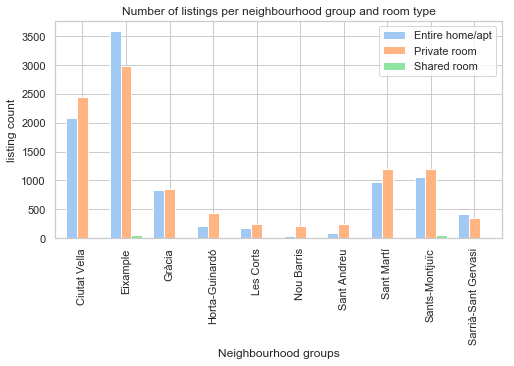

In [27]:
# plot data
sns.set(style="whitegrid", palette='pastel')

fig, ax = plt.subplots(figsize=(8,4));

lis.groupby(['neighbourhood_group','room_type']).count()['listing_id'].unstack().plot(ax=ax, kind="bar", width=0.75)
plt.title('Number of listings per neighbourhood group and room type')
plt.xlabel("Neighbourhood groups");
plt.ylabel("listing count");
plt.legend(loc='upper right');
plt.grid(True)

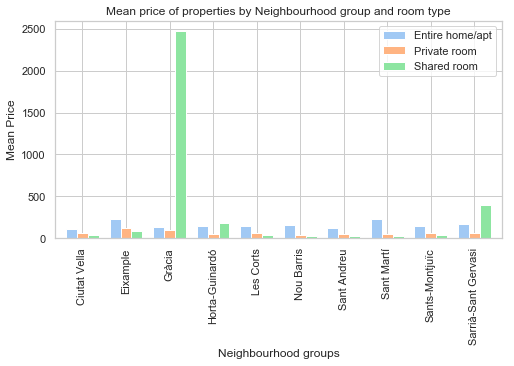

In [28]:
fig, ax = plt.subplots(figsize=(8,4));

df_lis.groupby(['neighbourhood_group','room_type']).mean()['price'].unstack().plot(ax=ax, kind="bar", width=0.75)
plt.title('Mean price of properties by Neighbourhood group and room type')
plt.xlabel("Neighbourhood groups");
plt.ylabel("Mean Price");
plt.legend(loc='upper right');

In [29]:
df_lis.groupby(['neighbourhood_group','room_type']).mean()['price'].unstack().sort_values(by='Shared room')

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Sant Andreu,119.239130,44.814516,20.600000
Sant Martí,226.029897,51.932780,26.700000
Nou Barris,155.312500,39.784314,30.857143
Sants-Montjuïc,146.983932,58.749580,38.333333
Ciutat Vella,111.631175,62.771966,40.111111
Les Corts,143.415301,65.271967,43.500000
Eixample,231.476867,122.350235,84.714286
Horta-Guinardó,146.759804,44.130734,183.200000
Sarrià-Sant Gervasi,164.807963,62.896848,397.500000


- In 'Entire home/apt' the top 2 are Eixample and Sant Marti
- In 'Private Room' the top 2 are Eixample and Gracia
- In 'Shared room' the top 2 are Gracia and Sarria-SantGervasi, but it's worth noting that there are potential outliers on shared rooms that may be poluting the result that have not been explored here.


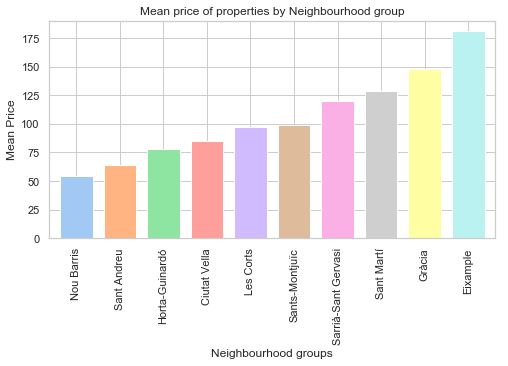

In [30]:
fig, ax = plt.subplots(figsize=(8,4));

df_lis.groupby(['neighbourhood_group']).mean()['price'].sort_values().plot(ax=ax, kind="bar", width=0.75)
plt.title('Mean price of properties by Neighbourhood group')
plt.xlabel("Neighbourhood groups");
plt.ylabel("Mean Price");

In [31]:
df_lis.groupby(['neighbourhood_group']).mean()['price'].sort_values()

neighbourhood_group
Nou Barris              54.740741
Sant Andreu             64.310145
Horta-Guinardó          77.668217
Ciutat Vella            84.982891
Les Corts               97.619816
Sants-Montjuïc          98.823197
Sarrià-Sant Gervasi    119.690231
Sant Martí             128.638724
Gràcia                 147.861988
Eixample               181.160072
Name: price, dtype: float64

> Overall, the top 2 are Eixample and Gracia as the most expensive lodgings

In [32]:
df_lis[['neighbourhood_group'
        , 'price'
        , 'listing_id'
        , 'number_of_reviews']].groupby(['neighbourhood_group']).agg({'price':['mean']
                                                                      , 'listing_id':['count']
                                                                      , 'number_of_reviews':['sum']})


,price,listing_id,number_of_reviews
,mean,count,sum
neighbourhood_group,,,
Ciutat Vella,84.982891,4559,125591
Eixample,181.160072,6622,250471
Gràcia,147.861988,1710,62019
Horta-Guinardó,77.668217,645,17356
Les Corts,97.619816,434,11255
Nou Barris,54.740741,243,4693
Sant Andreu,64.310145,345,6341
Sant Martí,128.638724,2195,67169


Instinctibly, we kind of know that the location of a property does influence its price, whether is for buying/selling or for lodging. The charts above show that there are cetairn areas where the prices are higher, even when looked at by different room types. However, let's look a little more in detail.

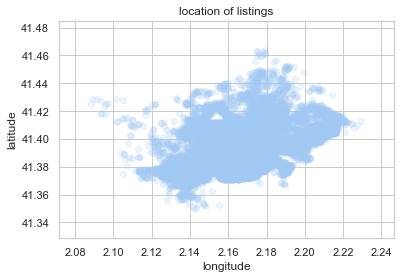

In [33]:
# Let's plot listings by location
plt.scatter(y=lis.latitude, x=lis.longitude, alpha=0.2);
plt.title('location of listings')
plt.ylabel("latitude");
plt.xlabel("longitude");

There are so many properties that it's hard to spot the "hot spots", let's try differently.

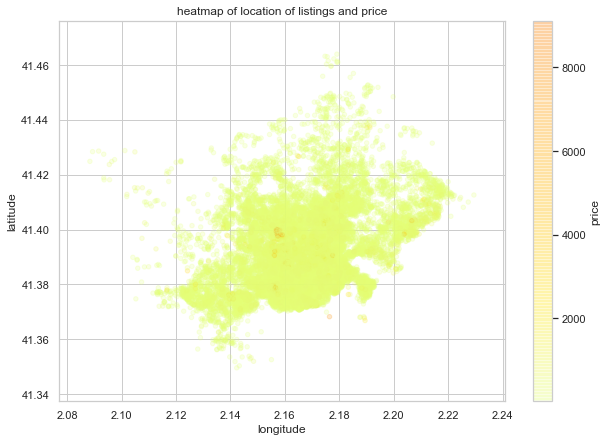

In [34]:
lis.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(10,7),
    c="price", cmap=plt.get_cmap("Wistia"), colorbar=True,
    sharex=False);
plt.title('heatmap of location of listings and price')
plt.ylabel("latitude");
plt.xlabel("longitude");

Although it's still a bit hard to see, there are few orange spot near the center of the city which indicate higher prices.

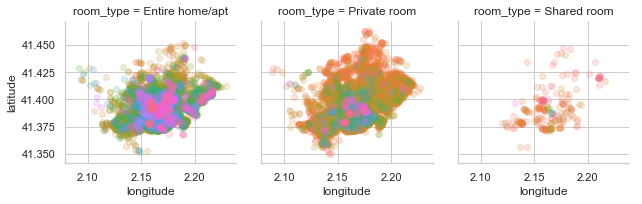

In [36]:
# and now let's use color to highlight price, but given that we can't really compare a mansion to a shared room in regards to listings, let's split them by the tipe of room offering
g = sns.FacetGrid(lis, col="room_type", hue="price");
g.map(plt.scatter, "longitude", "latitude", alpha=.2, cmap=plt.get_cmap("Wistia"));


Visually, we can see that the higher prices tend to be located near the center, in both three room types. To explore that bit further, let's get dummy variables for the neighbourhood groups so that we can assess their correlation with price.

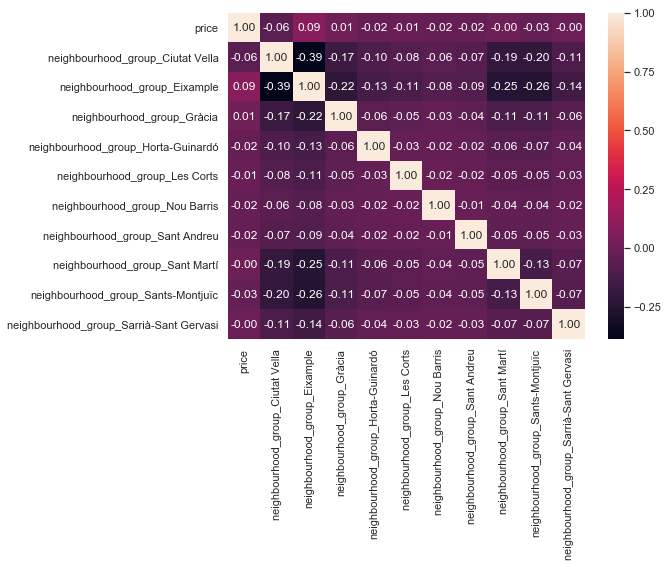

In [37]:
df_lis_dum = pd.get_dummies(df_lis[['neighbourhood_group', 'price']])

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_lis_dum.corr(), annot=True, fmt='.2f');                            

In [38]:
df_lis_dum_c = df_lis_dum.drop(columns='price')

In [39]:
# calculate pearsons correlation
from scipy.stats import pearsonr

for barrio in df_lis_dum_c.columns:
    corr, _ = pearsonr(df_lis_dum_c[barrio], df_lis_dum['price'])
    print('Pearsons correlation for ', barrio , ': %.3f' % corr)

Pearsons correlation for  neighbourhood_group_Ciutat Vella : -0.058
Pearsons correlation for  neighbourhood_group_Eixample : 0.086
Pearsons correlation for  neighbourhood_group_Gràcia : 0.013
Pearsons correlation for  neighbourhood_group_Horta-Guinardó : -0.022
Pearsons correlation for  neighbourhood_group_Les Corts : -0.011
Pearsons correlation for  neighbourhood_group_Nou Barris : -0.020
Pearsons correlation for  neighbourhood_group_Sant Andreu : -0.020
Pearsons correlation for  neighbourhood_group_Sant Martí : -0.001
Pearsons correlation for  neighbourhood_group_Sants-Montjuïc : -0.026
Pearsons correlation for  neighbourhood_group_Sarrià-Sant Gervasi : -0.005


> We could potentially conclude that for 2 of the "barrios" (neighbourhood groups) which we previously observed have higher prices on all room types, there's a small positive correlation between them and price for Eixample and Gracia, suggesting location has an influence in price for them.

### 2) Which locations receive the most reviews? What is the split between accomodation type and its reviews? What's the top reviewed property?

As you can probably have already seen, question number 2 isn't just a question, but a question and expanding slightly in it.

There's no information regarding the ranking or type of review, just the fact that there is a review so we can't tell if the review is positive or negative without interpreting the comment in it, so we won't be using much more than the review count as the purpose of this project isn't to analyse review texts.

In [40]:
# Which locations receive the most reviews
res1 = lis[['neighbourhood_group'
     , 'number_of_reviews'
     , 'listing_id']].groupby(['neighbourhood_group']).agg({"number_of_reviews": "sum"
                                                            , "listing_id": "count"}).reset_index()

res1.rename(columns={'number_of_reviews':'reviews_sum',
                    'listing_id':'listings_count'}, 
                 inplace=True)
res1['avg_reviews_per_listings'] = res1['reviews_sum'] / res1['listings_count']
res1.sort_values(by='avg_reviews_per_listings', ascending=False)

,neighbourhood_group,reviews_sum,listings_count,avg_reviews_per_listings
8,Sants-Montjuïc,87946,2302,38.204170
1,Eixample,250471,6622,37.824071
2,Gràcia,62019,1710,36.268421
7,Sant Martí,67169,2195,30.600911
0,Ciutat Vella,125591,4559,27.547927
3,Horta-Guinardó,17356,645,26.908527
4,Les Corts,11255,434,25.933180
9,Sarrià-Sant Gervasi,18038,778,23.185090
5,Nou Barris,4693,243,19.312757
6,Sant Andreu,6341,345,18.379710


> Sants-Montjuic, Eixample and Gracia are the top 3 most reviewed areas when taking into consideration the number of listings per area.

In [41]:
# stats on reviews per accomodation type
res2 = lis[['room_type', 'number_of_reviews', 'listing_id']].groupby(['room_type']).agg({'number_of_reviews':'sum', 
                                                                                  'listing_id':'count'}).reset_index()
res2.rename(columns={'number_of_reviews':'reviews_sum',
                    'listing_id':'listings_count'}, 
                 inplace=True)
res2['avg_reviews_per_listings'] = res2['reviews_sum'] / res2['listings_count']
res2.sort_values(by='avg_reviews_per_listings', ascending=False)

,room_type,reviews_sum,listings_count,avg_reviews_per_listings
0,Entire home/apt,342633,9475,36.161794
1,Private room,304417,10147,30.000690
2,Shared room,3829,211,18.146919


> Entire homes receive more reviews on average per listing.

In [42]:
# Listing with the highest number of reviews per month
lis.loc[df_lis["number_of_reviews"].idxmax()]

listing_id                                  1098571
name                              Plz REAL (Sq) kIT
host_id                                     5223863
host_name                                  Mercedes
neighbourhood_group                    Ciutat Vella
neighbourhood                        el Barri Gòtic
latitude                                    41.3796
longitude                                   2.17513
room_type                              Private room
price                                            49
minimum_nights                                    1
number_of_reviews                               645
last_review                              2019-07-07
reviews_per_month                               8.6
calculated_host_listings_count                    3
availability_365                                  0
Name: 883, dtype: object

In [43]:
cal[cal["listing_id"]==1098571].price.mean()

50.07671232876712

> Listing 1098571 is the most reviewed listing within Barcelona, located in Ciutat Vella and with an average price of €50 the night for a private room.

### 3) Can we predict the mean price or avg reviews based on seasonality?

So, let's look into the 3rd question which is the one that perhaps requires a bit more of "play". Can we detect sesonality and perhaps predict the price or even the number of reviews? Let's find out.

In [44]:
full_grp = full.groupby(['date']).price.mean()
full_grp.head(2)

date
2019-07-10    113.149781
2019-07-11    113.348681
Name: price, dtype: float64

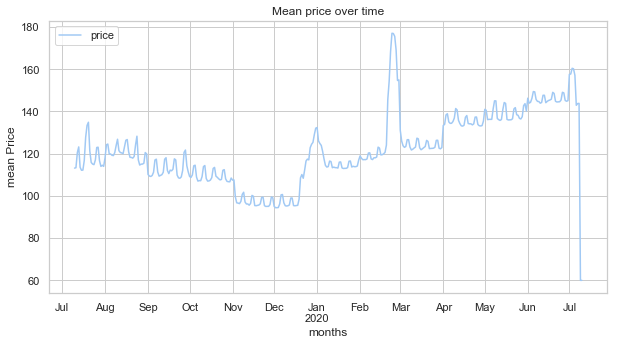

In [45]:
sns.set(style="whitegrid", palette='pastel')

fig, ax = plt.subplots(figsize=(10,5));
full_grp.plot(kind='line')
plt.title('Mean price over time')
plt.xlabel("months");
plt.ylabel("mean Price");
plt.legend(loc='upper left');


We can observe 2 particular spikes, which may fall within Christmas and Easter holidays. 

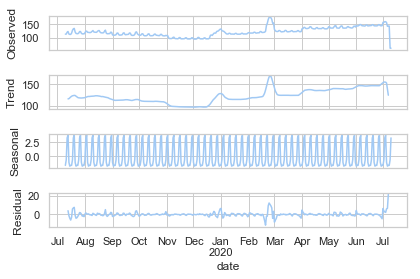

In [46]:
result = seasonal_decompose(full_grp, model='additive') 
result.plot()
plt.show()

In [47]:
full_grp = full_grp.reset_index()
full_grp.head(1)

,date,price
0,2019-07-10,113.149781


In [48]:
X = full_grp['date']
y = full_grp['price']
X = X.values.reshape(-1,1)

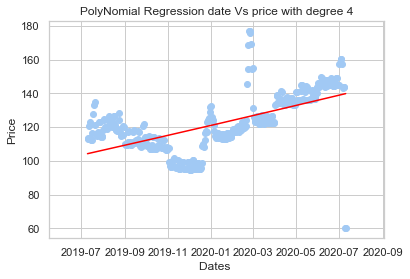

In [49]:
poly = PolynomialFeatures(degree = 4)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#normal regression
regressor=LinearRegression()
regressor.fit(X,y)

#ploting the data  
plt.scatter(X,y)
plt.plot(X,poly_regression.predict(poly_features), color='red')
plt.title("PolyNomial Regression date Vs price with degree 4")
plt.xlabel("Dates ")
plt.ylabel("Price")
plt.show()



Let's add neighbourhood group as a feature

In [50]:
def calculate_rscore(X_arr, y_arr, title):
    '''
    input: 
        X the columns to be used
        y the variable to be predicted
    return:
        rscore, X_train, X_test, y_train, y_test, y_test_preds
    '''
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size = .5, random_state=42) 

    # train data
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 
    rscore = r2_score(y_test, y_test_preds)
    print("R-squared: {} is {:.1%} on {} values.".format(title, rscore, len(y_test))) 
    r_squared = r2_score(y_test, y_test_preds)
    plt.scatter(y_test,y_test_preds, alpha=0.5, color="green")
    plt.title('Actual vs Predicted'.format(title))
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')

    plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_preds, 1))(np.unique(y_test)))
    plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
    plt.show()
    return rscore, X_train, X_test, y_train, y_test, y_test_preds

R-squared: all neighbourhoods is 75.6% on 1826 values.


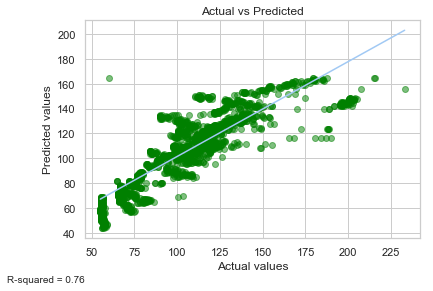

In [53]:
import datetime as dt

full_grp = full.groupby(['date','neighbourhood_group']).price.mean().reset_index()
full_grp = pd.get_dummies(full_grp)

# in order to use the date in the model, we need to convert it to numeric
full_grp['date']=full_grp['date'].map(dt.datetime.toordinal)

# the model considering neighbourhoods as well as dates
X = full_grp.drop(columns=['price'])
y = full_grp['price']
title = 'all neighbourhoods'
rscore, X_train, X_test, y_train, y_test, y_test_preds = calculate_rscore(X, y, title)


> According to this, we could predict the mean price for a property in Barcelona with 75.6% accuracy.